6.979703430337763
7
4.96035637156014
4.949747468305833


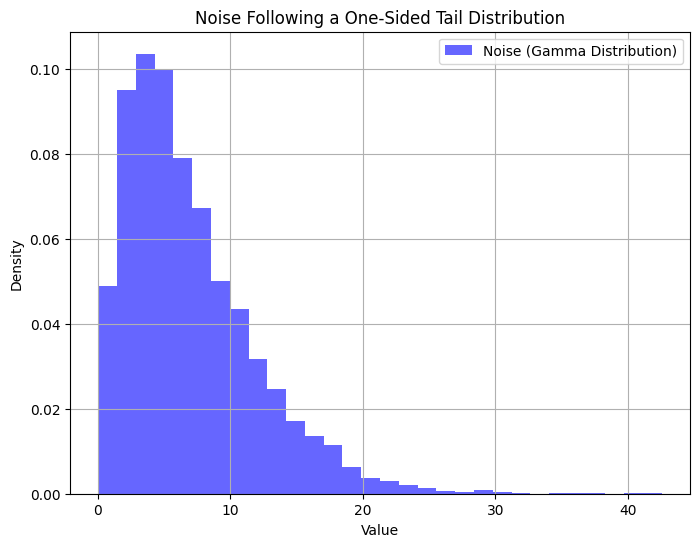

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Set parameters
a = 2  # Shape parameter (adjust to control tail behavior)
desired_mean = 7
scale_gamma = desired_mean / a  # Scale parameter (adjust to control spread)
ground_true_std = scale_gamma * np.sqrt(a)

# Calculate the scale parameter based on the desired mean

num_samples = 5000

# Generate noise following a gamma distribution (one-sided tail)
noise = gamma.rvs(a=a, scale=scale_gamma, size=num_samples)
print(noise.mean())
print(desired_mean)
print(noise.std())
print(ground_true_std)

# Plot the histogram of the noise
plt.figure(figsize=(8, 6))
plt.hist(noise, bins=30, density=True, alpha=0.6, color='blue', label='Noise (Gamma Distribution)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Noise Following a One-Sided Tail Distribution')
plt.legend()
plt.grid(True)
plt.show()

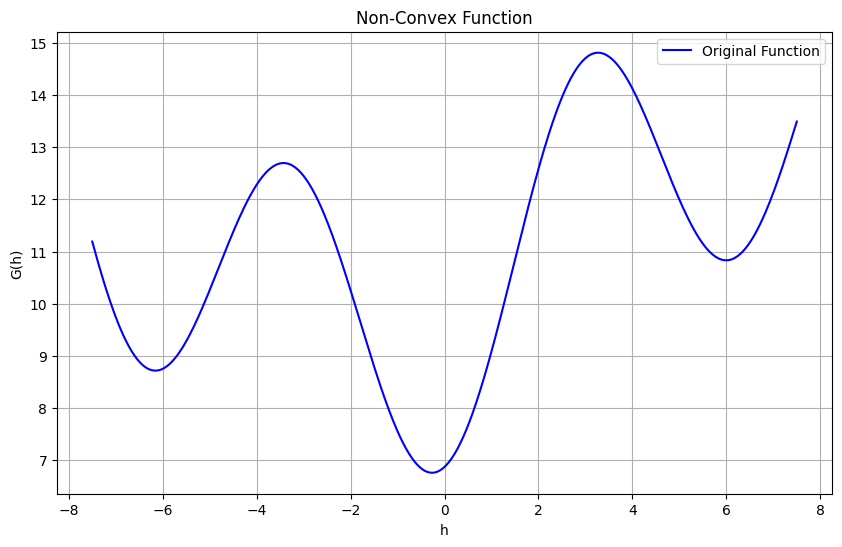

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Define the non-convex function
def non_convex_function(x):
    return (4 * np.sin((x - 3) / 3) + 5 * np.cos(x - 3) + 20) / 1.7


# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Plot the original and noisy functions
plt.figure(figsize=(10, 6))
plt.plot(x, non_convex_function(x), label='Original Function', color='blue')
plt.xlabel('h')
plt.ylabel('G(h)')
plt.title('Non-Convex Function')
plt.legend()
plt.grid(True)
plt.show()

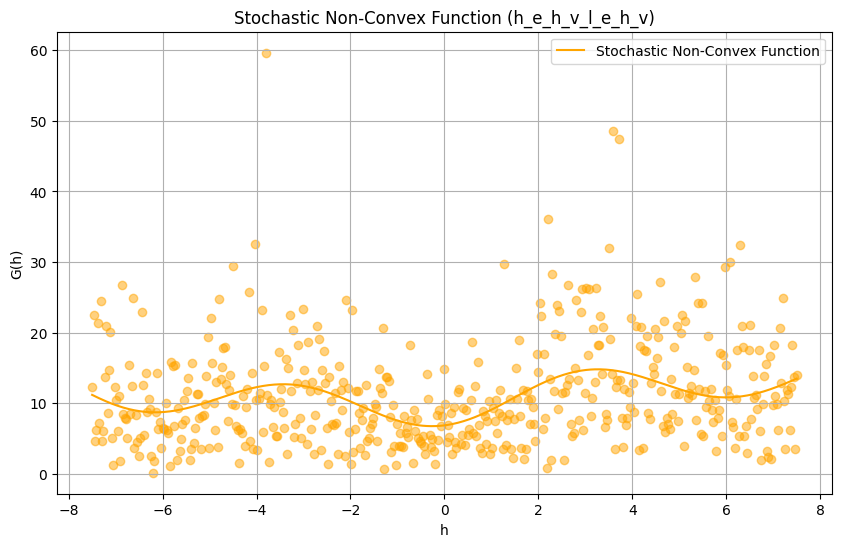

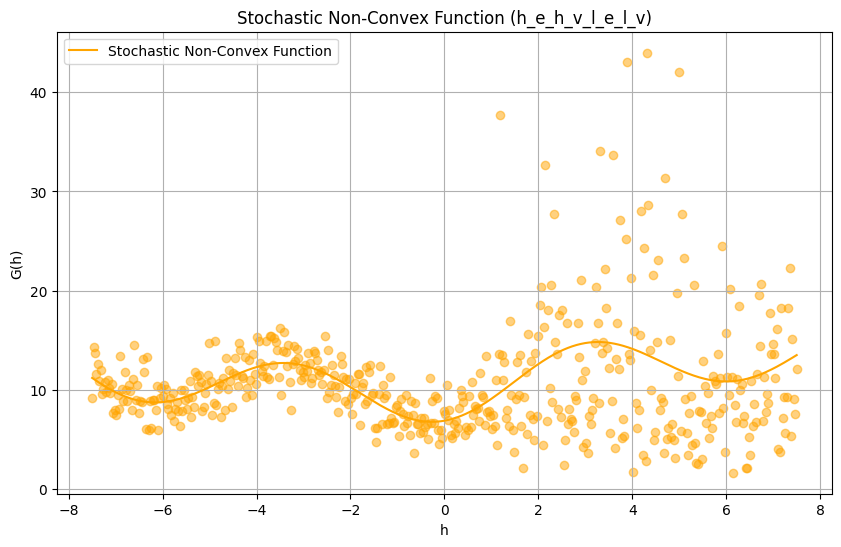

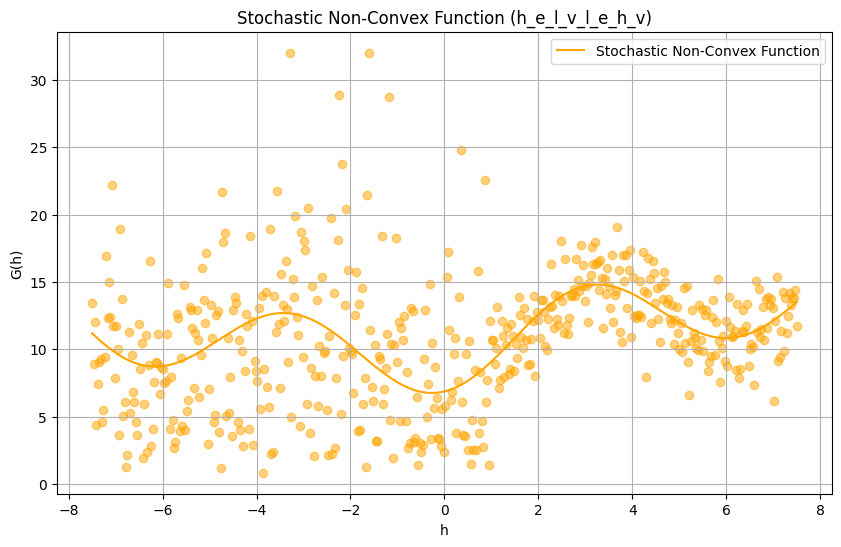

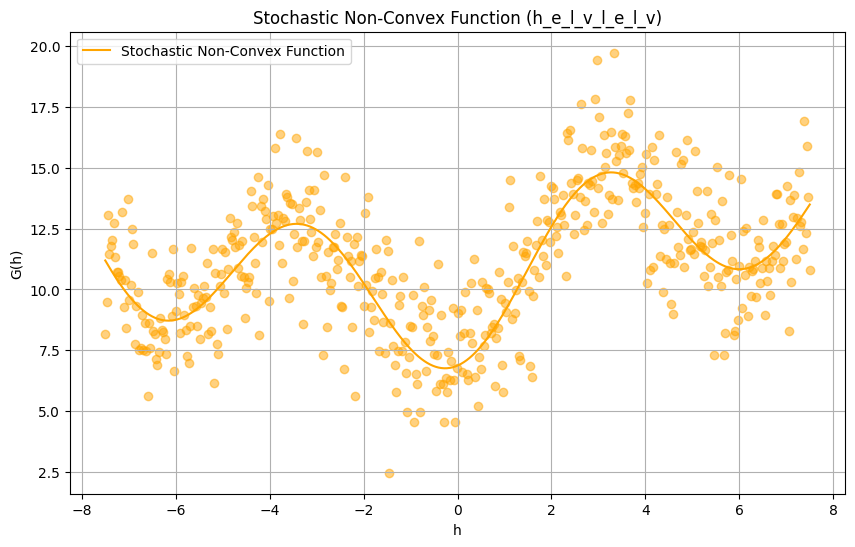

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm


# Define the non-convex function
def non_convex_function(x):
    return (4 * np.sin((x - 3) / 3) + 5 * np.cos(x - 3) + 20) / 1.7

# Define the noisy function values based on the provided code
noise_function_modes = ["h_e_h_v_l_e_h_v", "h_e_h_v_l_e_l_v", "h_e_l_v_l_e_h_v", "h_e_l_v_l_e_l_v"]
# human readable
function_modes = {"h_e_h_v_l_e_h_v": "Optimal Region with Slightly Higher Risk",
                  "h_e_h_v_l_e_l_v": "Sub-optimal Region with Dramatically Lower Risk",
                  "h_e_l_v_l_e_h_v": "Optimal Region with Dramatically Lower Risk",
                  "h_e_l_v_l_e_l_v": "All Regions with Similar Risk"}
def non_convex_noisy_function(x, noise_function_mode):
    # Set parameters for the gamma distribution noise
    a_gamma = 3
    desired_mean = non_convex_function(x)

    # Calculate the scale parameter based on the desired mean
    scale_gamma = desired_mean / a_gamma

    # Set parameters for the normal distribution noise
    mean_normal = 0
    std_normal = 1.8  # Smaller standard deviation for less variance

    if noise_function_mode == "h_e_l_v_l_e_h_v":
        if x < 1:
            # Generate noise following a gamma distribution (one-sided tail)
            gamma_noise = gamma.rvs(a=a_gamma, scale=scale_gamma, size=1)
            noise = gamma_noise
            noisy_function_values = noise
            std = scale_gamma * np.sqrt(a_gamma)
        else:
            # Generate normal noise with less variance for interval [0, 6]
            normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
            noise = normal_noise
            noisy_function_values = non_convex_function(x) + noise
            std = std_normal
    elif noise_function_mode == "h_e_l_v_l_e_l_v":
        normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
        noise = normal_noise
        noisy_function_values = non_convex_function(x) + noise
        std = std_normal
    elif noise_function_mode == "h_e_h_v_l_e_h_v":
        # Generate noise following a gamma distribution (one-sided tail)
        gamma_noise = gamma.rvs(a=a_gamma, scale=scale_gamma, size=1)
        noise = gamma_noise
        noisy_function_values = noise
        std = scale_gamma * np.sqrt(a_gamma)
    elif noise_function_mode == "h_e_h_v_l_e_l_v":
        if x > 1:
            # Generate noise following a gamma distribution (one-sided tail)
            gamma_noise = gamma.rvs(a=a_gamma, scale=scale_gamma, size=1)
            noise = gamma_noise
            noisy_function_values = noise
            std = scale_gamma * np.sqrt(a_gamma)
        else:
            # Generate normal noise with less variance for interval [0, 6]
            normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
            noise = normal_noise
            noisy_function_values = non_convex_function(x) + noise
            std = std_normal
    
    return noisy_function_values, std

# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Calculate the original non-convex function values
original_function_values = non_convex_function(x)

for noise_function_mode in noise_function_modes:
    # Calculate the noisy function values
    noisy_function_values = np.array([])
    stds = np.array([])
    for xi in x:
        # append the noisy function values to the array
        v, std = non_convex_noisy_function(xi, noise_function_mode)
        noisy_function_values = np.append(noisy_function_values, v)
        stds = np.append(stds, std)

    # Plot the functions
    plt.figure(figsize=(10, 6))
    plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
    # plot std
    # plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
    plt.scatter(x, noisy_function_values, alpha=0.5, color='orange')
    plt.xlabel('h')
    plt.ylabel('G(h)')
    plt.title(f'Stochastic Non-Convex Function ({noise_function_mode})')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

In [29]:
import optuna
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler
import pandas as pd
import pickle

# spec
noise_function_modes = ["h_e_h_v_l_e_h_v", "h_e_h_v_l_e_l_v", "h_e_l_v_l_e_h_v", "h_e_l_v_l_e_l_v"]
samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR",
              "dynamics_runs_w/o_CVaR"]
budgets = ['num_of_trials', 'num_of_eval']
times = 120
# trials = [10]
trials = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
reptition = 2
alpha = 0.5
warm_trials = 1
threshold = 1.5

def _compute_cvar(returns: np.ndarray, alpha: float = 0.2) -> float:
    """ Compute CVaR

    """
    returns = np.array(returns)
    assert returns.ndim == 1, "returns must be 1D array"
    sorted_returns = np.sort(returns)
    n = len(sorted_returns)
    VaR_idx = int(alpha * n)
    if VaR_idx == 0:
        VaR_idx = 1
    
    CVaR = sorted_returns[:VaR_idx].mean()

    return CVaR

def objective(trial, s, noise_function_mode):
    G = 0
    if s == "naive_single_run":
        h = trial.suggest_float("h", -7.5, 7.5)
        G, _ = non_convex_noisy_function(h, noise_function_mode)
        with open("num_of_eval.pickle", "rb") as fin:
            num_of_eval = pickle.load(fin)
        num_of_eval += 1
        with open("num_of_eval.pickle", "wb") as fout:
            pickle.dump(num_of_eval, fout)
    elif s == "naive_multiple_runs":
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        for _ in range(reptition):
            v, _ = non_convex_noisy_function(h, noise_function_mode)
            f.append(v)
            with open("num_of_eval.pickle", "rb") as fin:
                num_of_eval = pickle.load(fin)
            num_of_eval += 1
            with open("num_of_eval.pickle", "wb") as fout:
                pickle.dump(num_of_eval, fout)
        G = np.mean(f)
    elif s == "multiple_runs_w/_CVaR":
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        for _ in range(reptition):
            v, _ = non_convex_noisy_function(h, noise_function_mode)
            f.append(v[0])
            with open("num_of_eval.pickle", "rb") as fin:
                num_of_eval = pickle.load(fin)
            num_of_eval += 1
            with open("num_of_eval.pickle", "wb") as fout:
                pickle.dump(num_of_eval, fout)
        G = _compute_cvar(f, alpha)
    elif s == "dynamics_runs_w/_CVaR":
        increase_runs = True
        first_iteration = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            if first_iteration:
                Gs = np.inf
            for _ in range(reptition):
                v, _ = non_convex_noisy_function(h, noise_function_mode)
                f.append(v[0])
                with open("num_of_eval.pickle", "rb") as fin:
                    num_of_eval = pickle.load(fin)
                num_of_eval += 1
                with open("num_of_eval.pickle", "wb") as fout:
                    pickle.dump(num_of_eval, fout)
            Gss = _compute_cvar(np.array(f), alpha)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value or first_iteration == False:
                    if abs(Gs - Gss) > threshold:
                        increase_runs = True
                        first_iteration = False
                        Gs = Gss
                    else:
                        increase_runs = False
        G = Gss
    elif s == "dynamics_runs_w/o_CVaR":
        increase_runs = True
        first_iteration = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            if first_iteration:
                Gs = np.inf
            for _ in range(reptition):
                v, _ = non_convex_noisy_function(h, noise_function_mode)
                f.append(v[0])
                with open("num_of_eval.pickle", "rb") as fin:
                    num_of_eval = pickle.load(fin)
                num_of_eval += 1
                with open("num_of_eval.pickle", "wb") as fout:
                    pickle.dump(num_of_eval, fout)
            Gss = np.mean(f)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value or first_iteration == False:
                    if abs(Gs - Gss) > threshold:
                        increase_runs = True
                        first_iteration = False
                        Gs = Gss
                    else:
                        increase_runs = False
        G = Gss
    return G
    

optuna.logging.set_verbosity(optuna.logging.WARNING)
# Create an empty DataFrame
df = pd.DataFrame(columns=['Sampler', 'G', 'std', 'h', 'Strategy', 'num_of_eval', 'num_of_trials'])
for noise_function_mode in noise_function_modes:
    for trial in trials:
        for sampler in samplers:
            for s in strategies:
                for _ in range(times):
                    num_of_eval = 0
                    with open("num_of_eval.pickle", "wb") as fout:
                        pickle.dump(num_of_eval, fout)
                    if sampler == "TPESampler":
                        study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                    elif sampler == "RandomSampler":
                        study = optuna.create_study(sampler=RandomSampler(), direction="maximize")

                    study.optimize(lambda trial: objective(trial, s, noise_function_mode), n_trials=trial)
                    best_params = study.best_params
                    with open("num_of_eval.pickle", "rb") as fin:
                        num_of_eval = pickle.load(fin)
                    _, std = non_convex_noisy_function(best_params["h"], noise_function_mode)
                    # Append data to temporary DataFrame
                    temp_df = pd.DataFrame({"Sampler": [sampler],
                                            "G": [non_convex_function(best_params["h"])],
                                            'std': [std],
                                            "h": [best_params["h"]],  
                                            "Strategy": [s],
                                            "num_of_eval": [num_of_eval],
                                            "num_of_trials": [len(study.trials)],
                                            "noise_function_modes": [noise_function_mode]})

                    # Concatenate temporary DataFrame with main DataFrame
                    df = pd.concat([df, temp_df], ignore_index=True)

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

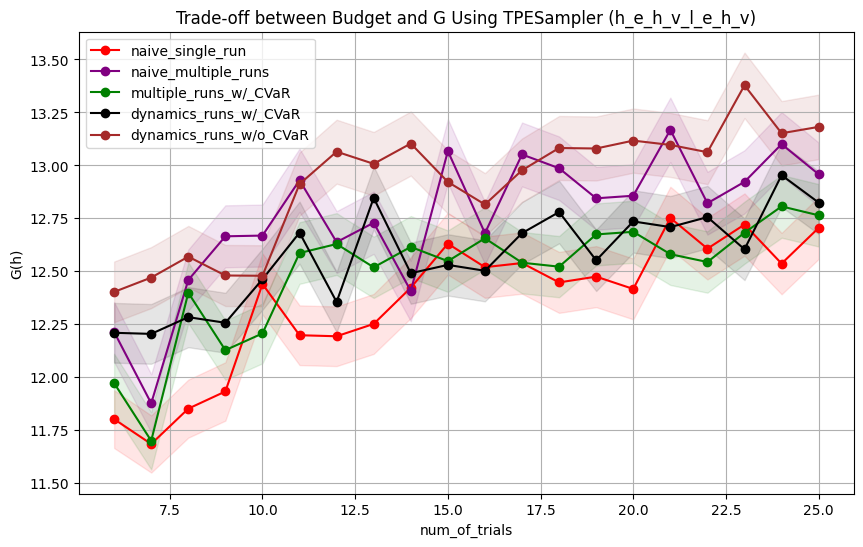

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

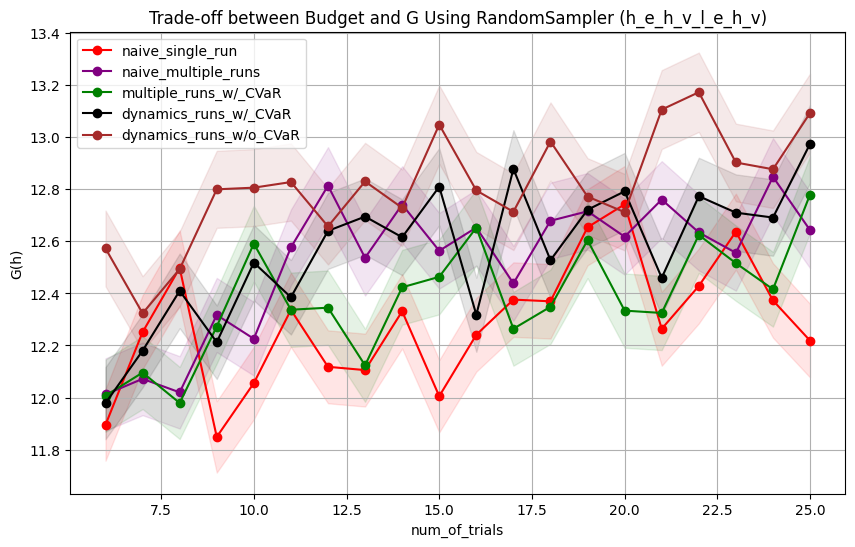

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

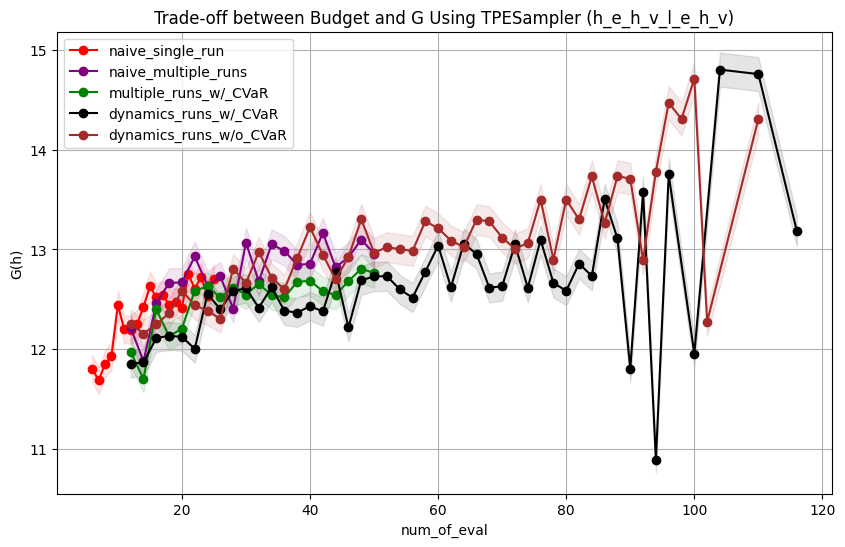

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

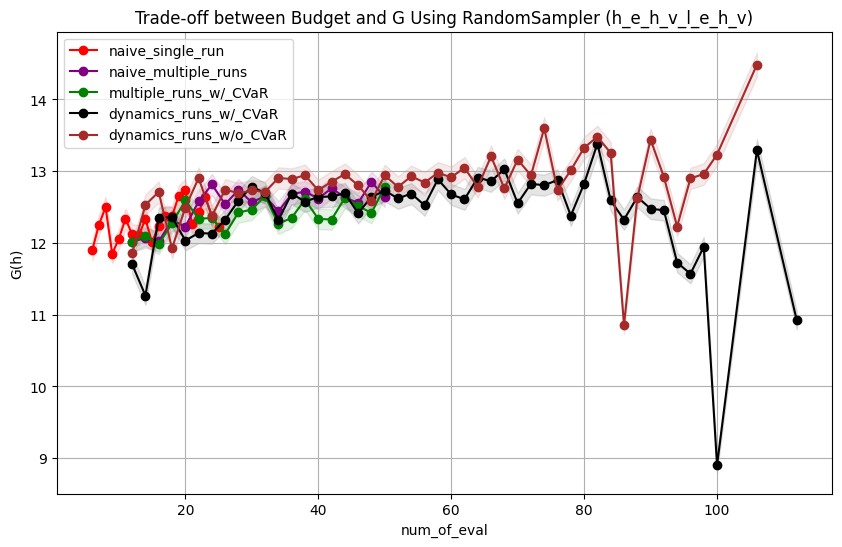

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

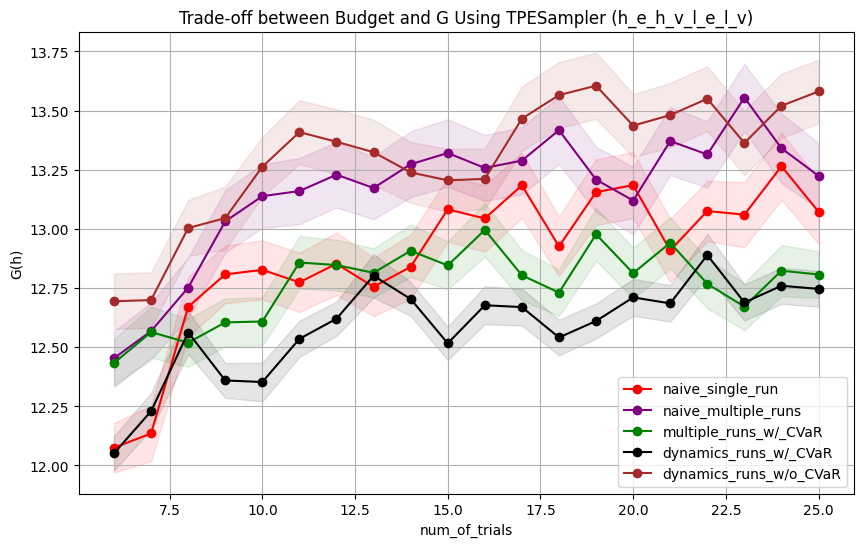

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

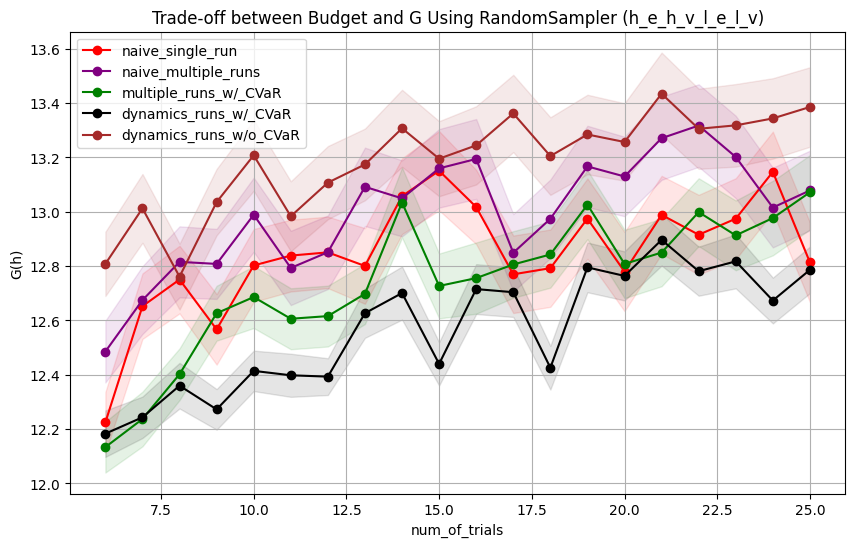

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

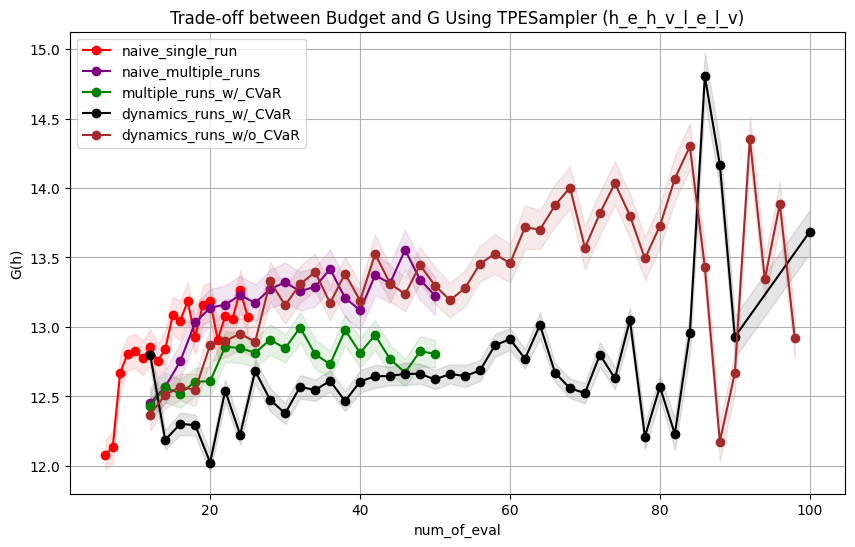

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

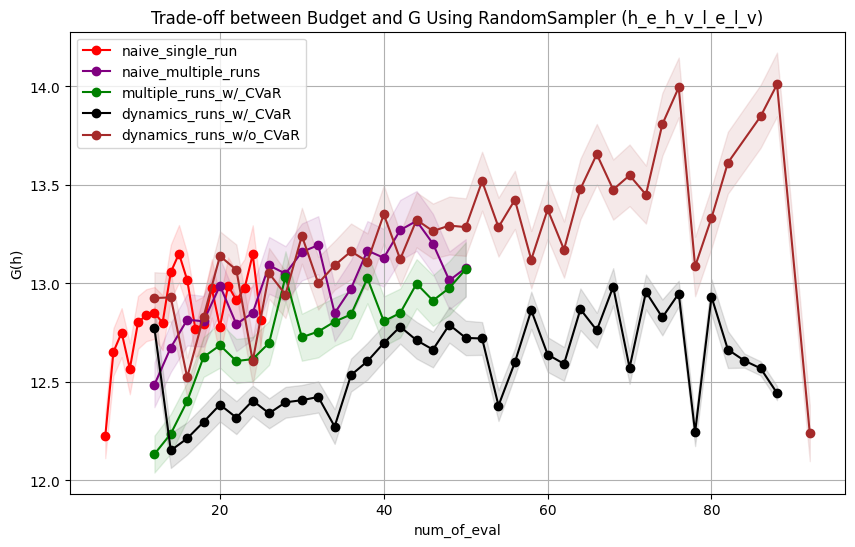

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

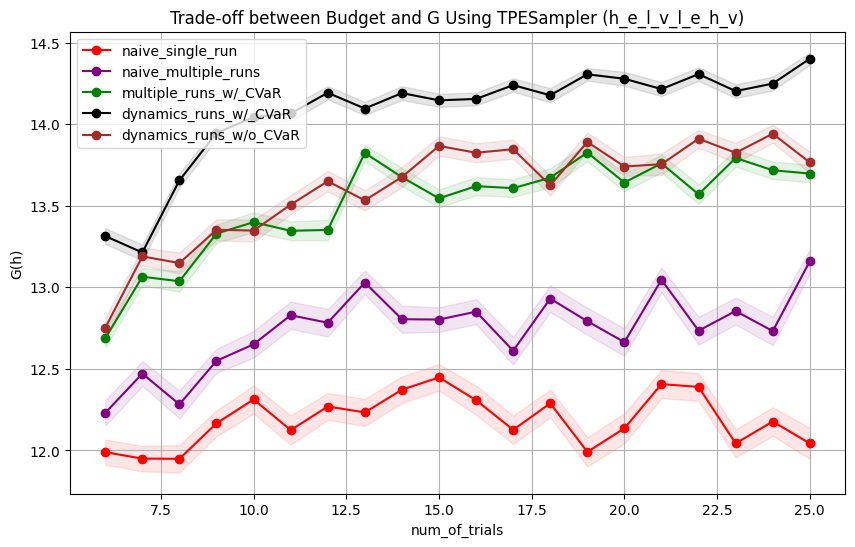

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

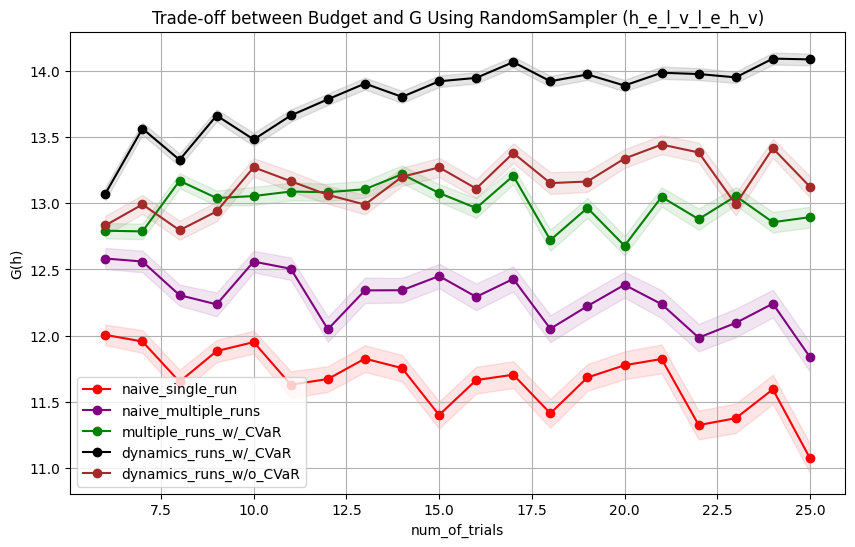

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

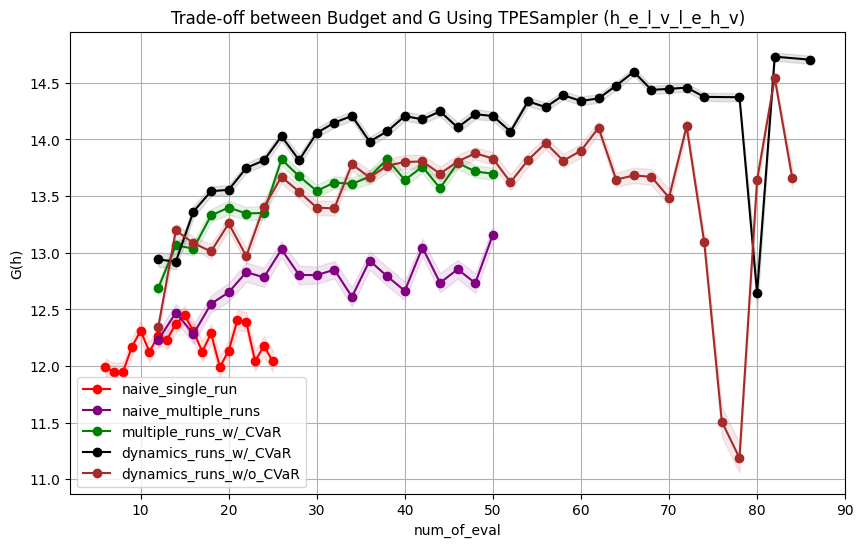

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

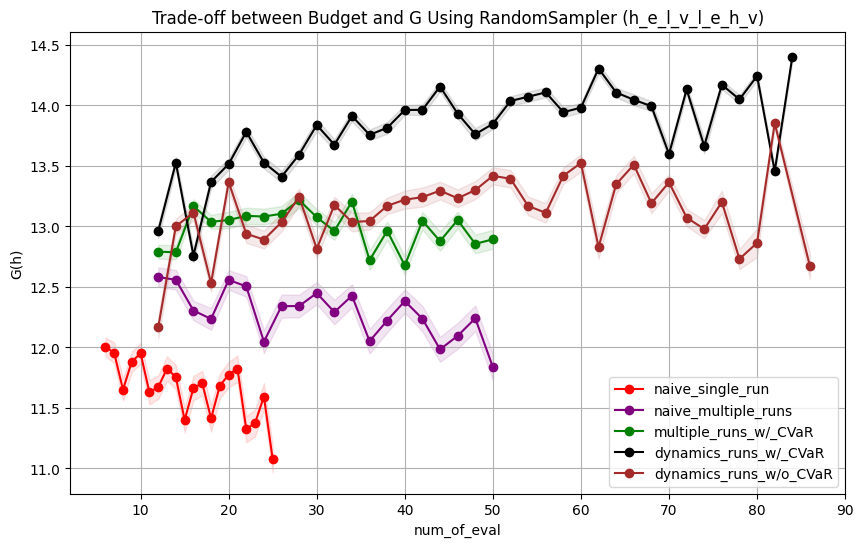

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

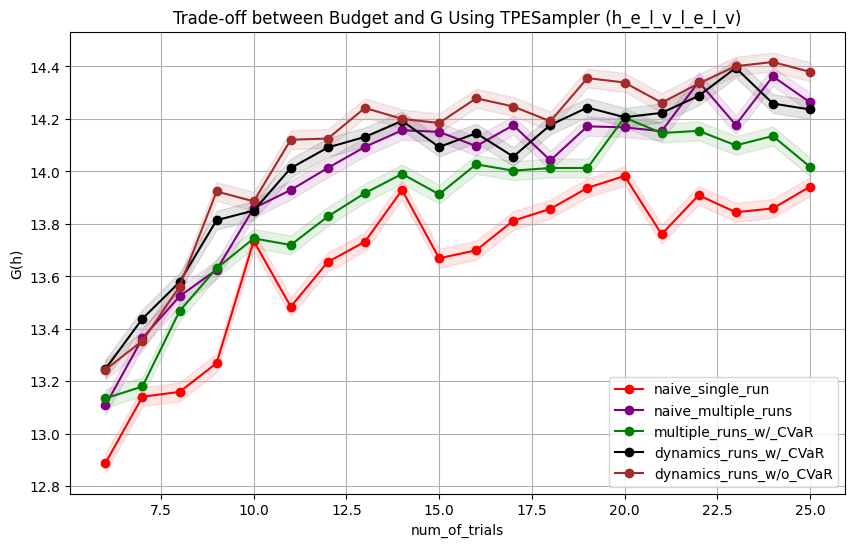

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

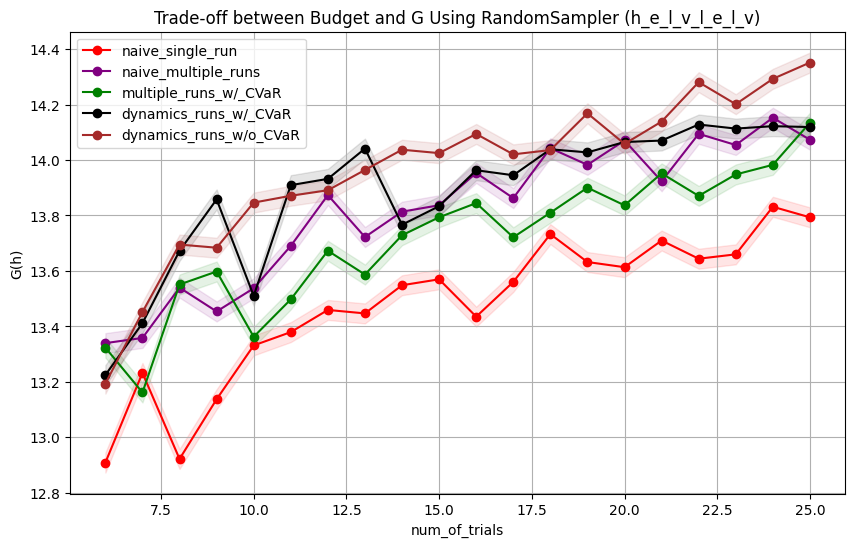

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

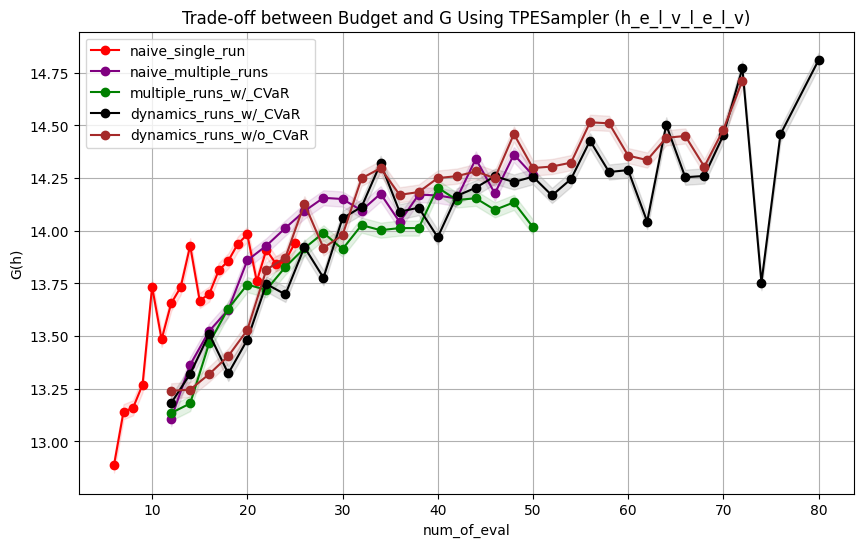

/tmp/ipykernel_2465475/50932105.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
/tmp/ipykernel_2465475/50932105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
/tmp/ipykernel_2465475/50932105.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sam

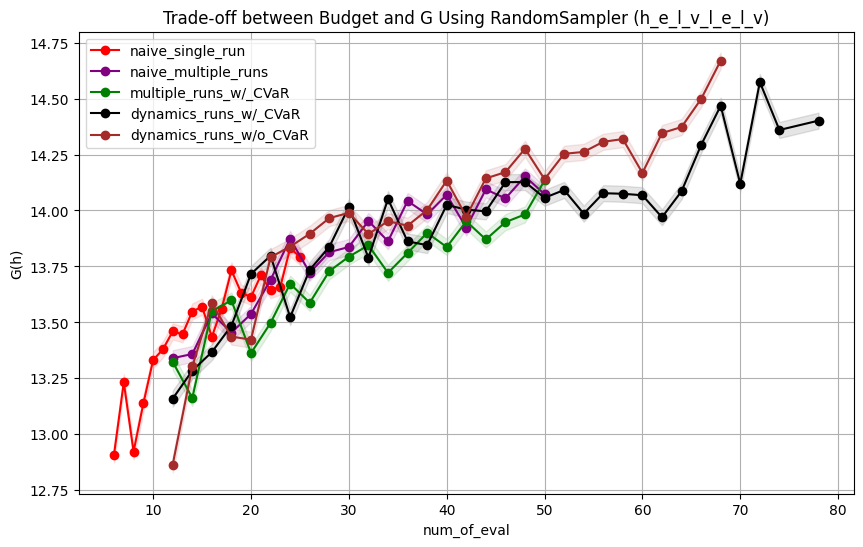

In [30]:
samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR",
              "dynamics_runs_w/o_CVaR"]
budgets = ['num_of_trials', 'num_of_eval']
# visualize the results
for noise_function_mode in noise_function_modes:
        for budget in budgets:
                for sampler in samplers:
                        plt.figure(figsize=(10, 6))
                        # plot data points for each strategy
                        plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(), 
                                df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
                                'o-', label=strategies[0], color='red')
                        plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean() - 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['std'].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['G'].mean() + 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[0]].groupby(budget)['std'].mean(),
                                        alpha=0.1, color='red')
                        plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[1]].groupby(budget)[budget].mean(),
                                df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[1]].groupby(budget)['G'].mean(),
                                'o-', label=strategies[1], color='purple')
                        plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[1]].groupby(budget)[budget].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[1]].groupby(budget)['G'].mean() - 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[1]].groupby(budget)['std'].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[1]].groupby(budget)['G'].mean() + 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[1]].groupby(budget)['std'].mean(),
                                        alpha=0.1, color='purple')
                        plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[2]].groupby(budget)[budget].mean(),
                                df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[2]].groupby(budget)['G'].mean(),
                                'o-', label=strategies[2], color='green')
                        plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[2]].groupby(budget)[budget].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[2]].groupby(budget)['G'].mean() - 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[2]].groupby(budget)['std'].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[2]].groupby(budget)['G'].mean() + 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[2]].groupby(budget)['std'].mean(),
                                        alpha=0.1, color='green')
                        plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[3]].groupby(budget)[budget].mean(),
                                df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[3]].groupby(budget)['G'].mean(),
                                'o-', label=strategies[3], color='black')
                        plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[3]].groupby(budget)[budget].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[3]].groupby(budget)['G'].mean() - 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[3]].groupby(budget)['std'].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[3]].groupby(budget)['G'].mean() + 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[3]].groupby(budget)['std'].mean(),
                                        alpha=0.1, color='black')
                        plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[4]].groupby(budget)[budget].mean(),
                                df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[4]].groupby(budget)['G'].mean(),
                                'o-', label=strategies[4], color='brown')
                        plt.fill_between(df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[4]].groupby(budget)[budget].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[4]].groupby(budget)['G'].mean() - 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[4]].groupby(budget)['std'].mean(),
                                        df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[4]].groupby(budget)['G'].mean() + 0.02*df[df['noise_function_modes'] == noise_function_mode][df['Sampler'] == sampler][df['Strategy'] == strategies[4]].groupby(budget)['std'].mean(),
                                        alpha=0.1, color='brown')
                        plt.xlabel(budget)
                        plt.ylabel('G(h)')
                        plt.title('Trade-off between Budget and G Using ' + sampler + f' ({noise_function_mode})')
                        plt.legend()
                        plt.grid(True)
                        plt.show()
                        plt.close()

/tmp/ipykernel_2465475/1553960541.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['num_of_trials'] == trial_to_describe][df['Sampler'] == sampler][df['Strategy'] == strategy]['h'],
/tmp/ipykernel_2465475/1553960541.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['noise_function_modes'] == noise_function_mode][df['num_of_trials'] == trial_to_describe][df['Sampler'] == sampler][df['Strategy'] == strategy]['G'],
/tmp/ipykernel_2465475/1553960541.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['noise_function_modes'] == noise_function_mode][df['num_of_trials'] == trial_to_describe][df['Sampler'] == sampler][df['Strategy'] == strategy]['h'],


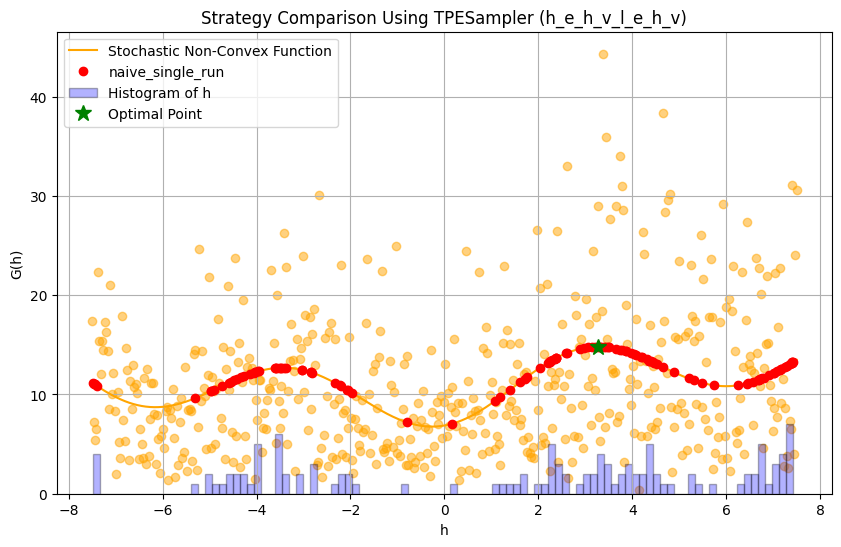

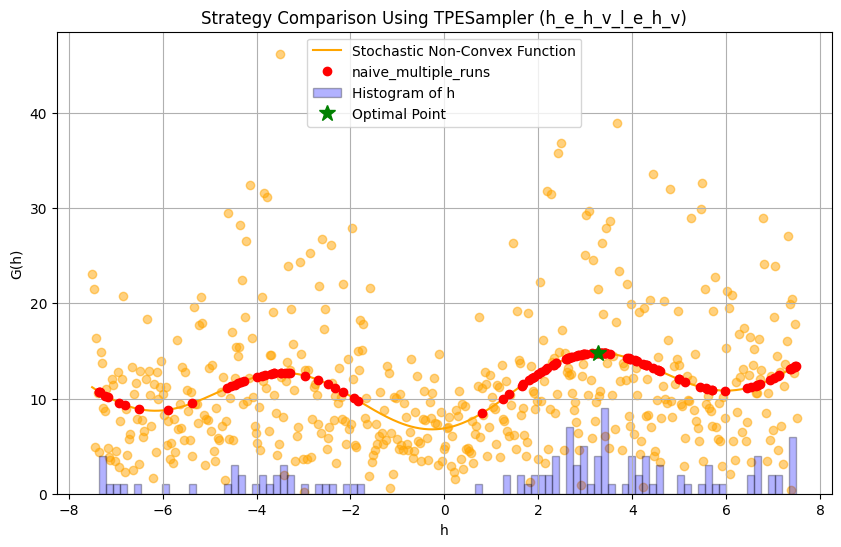

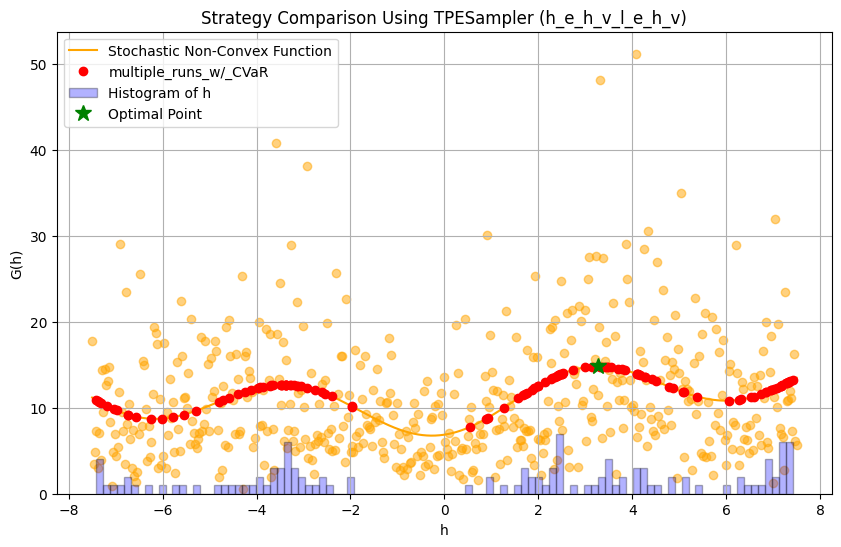

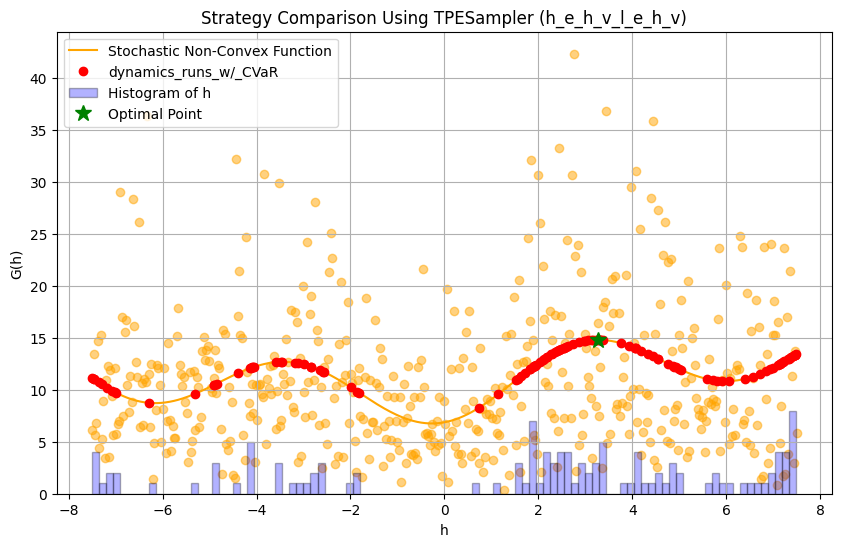

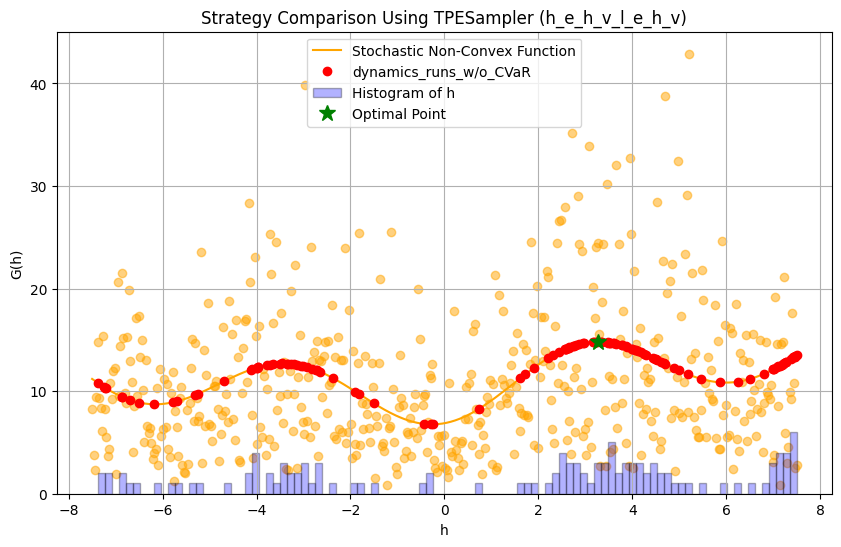

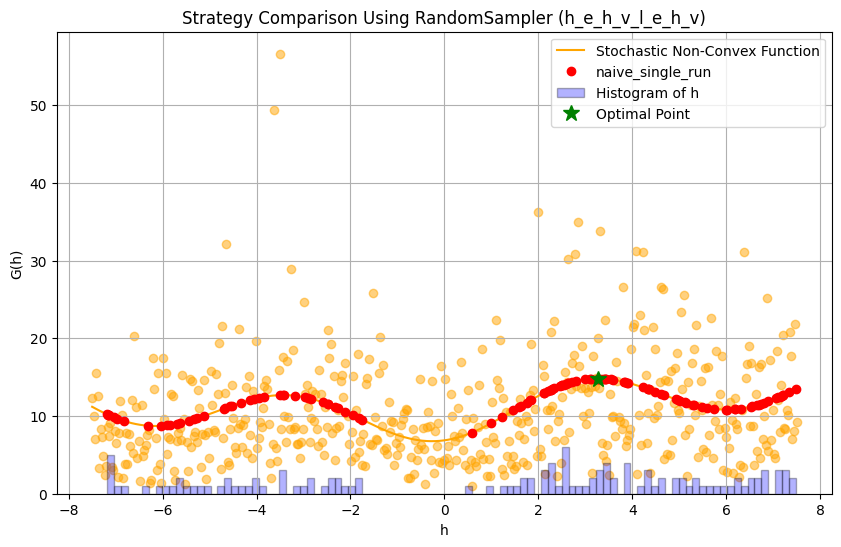

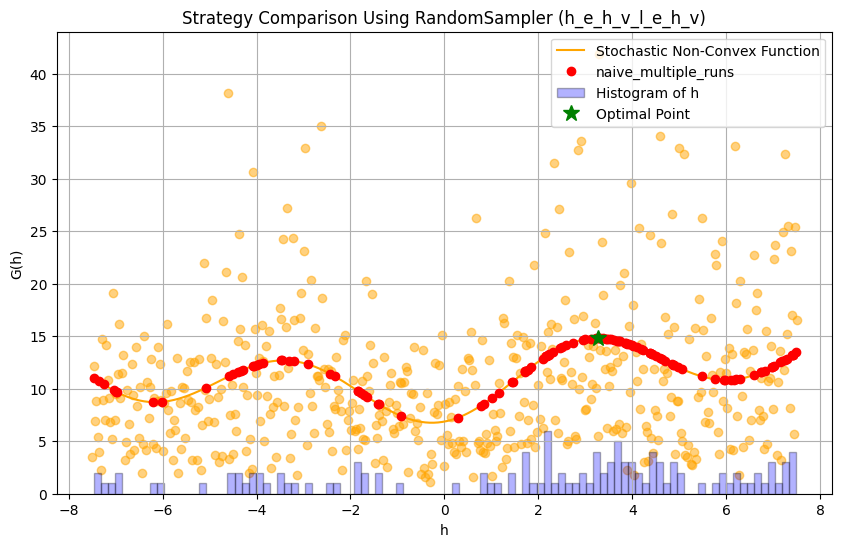

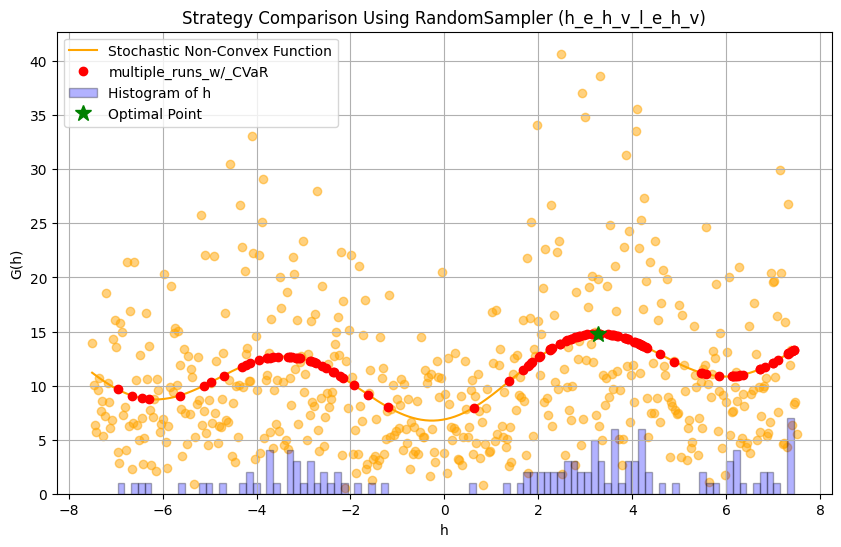

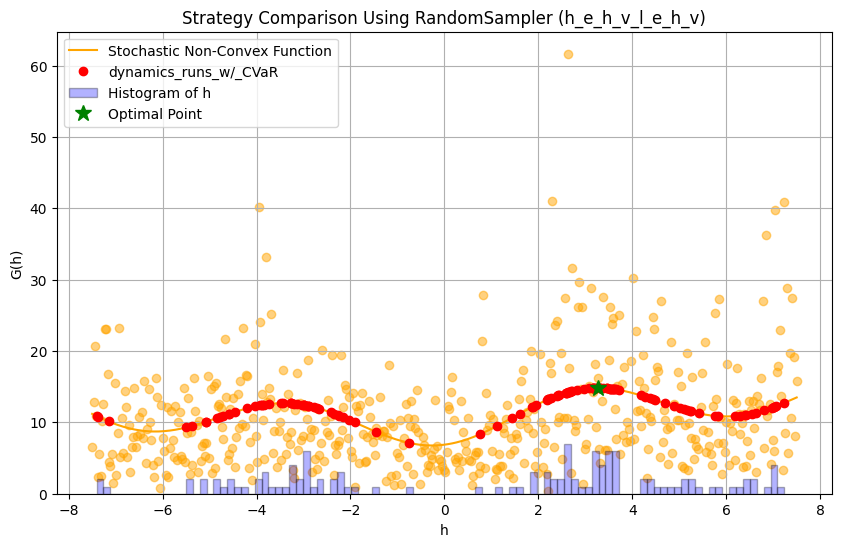

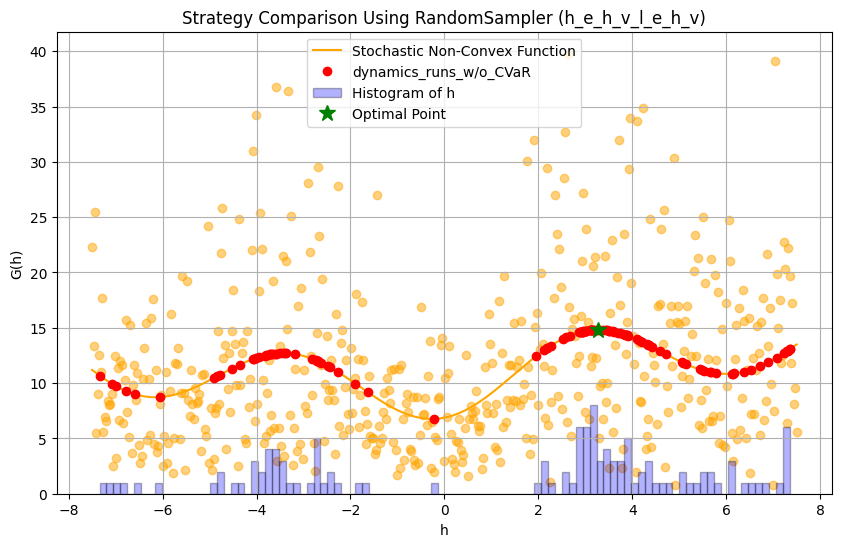

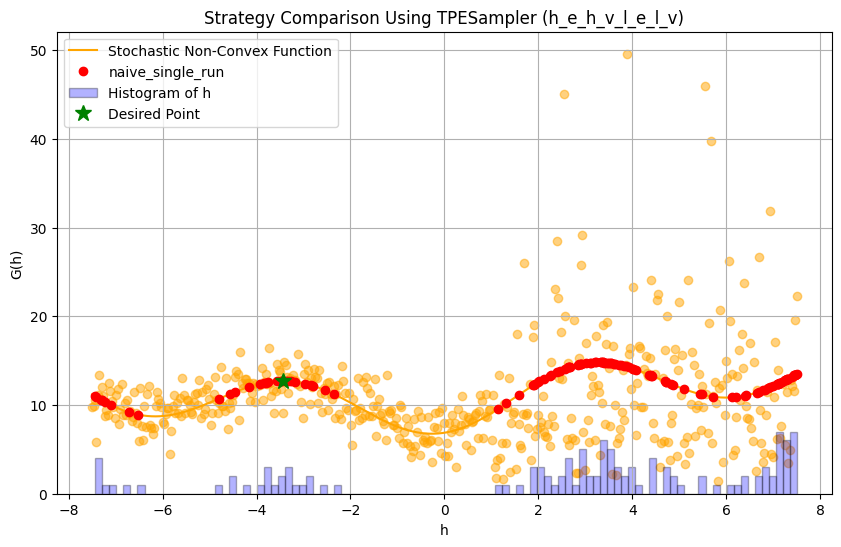

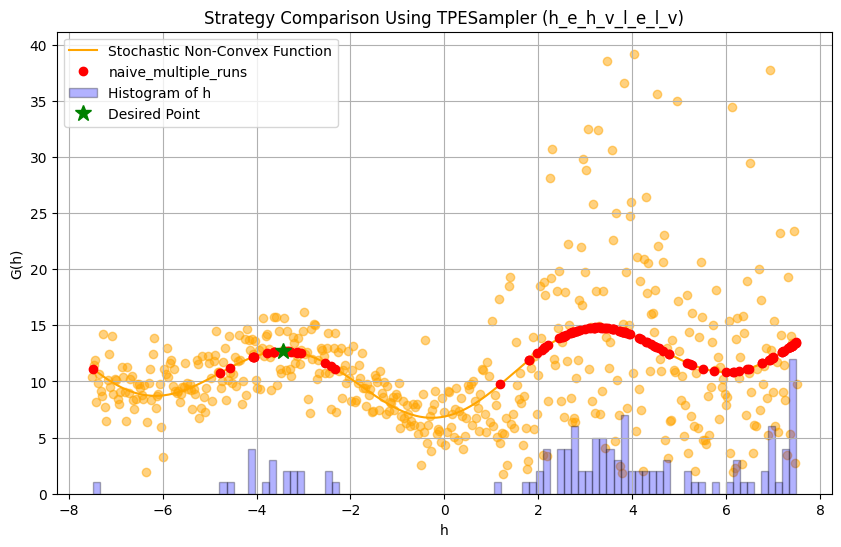

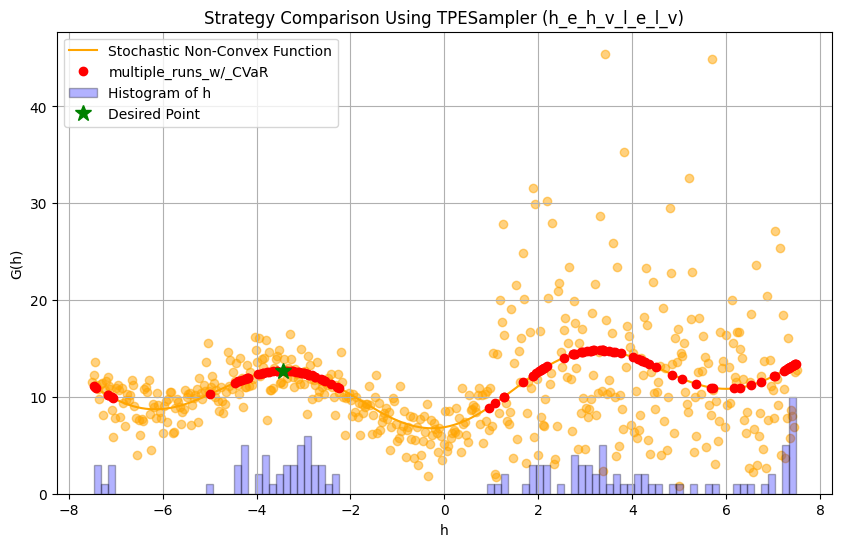

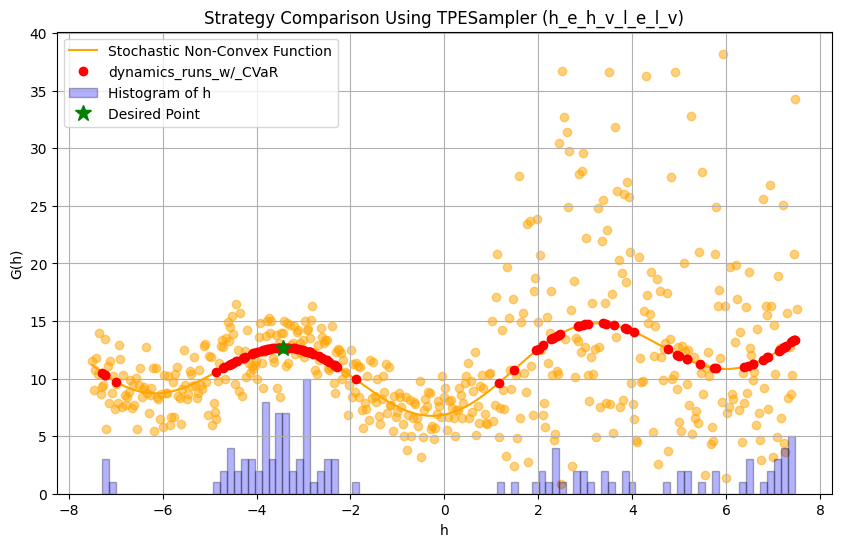

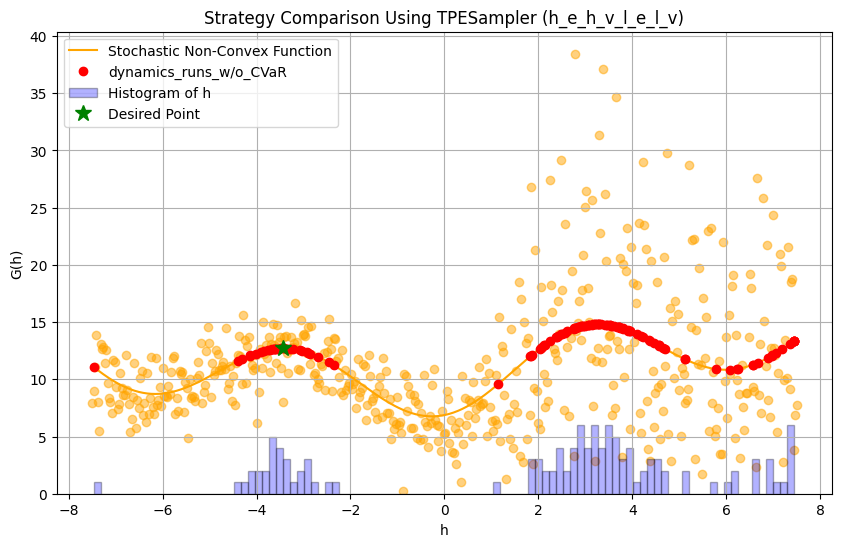

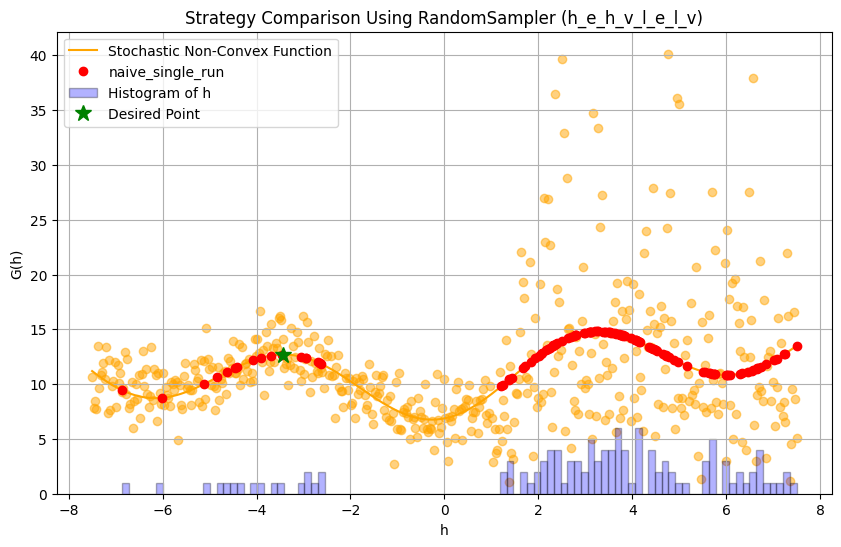

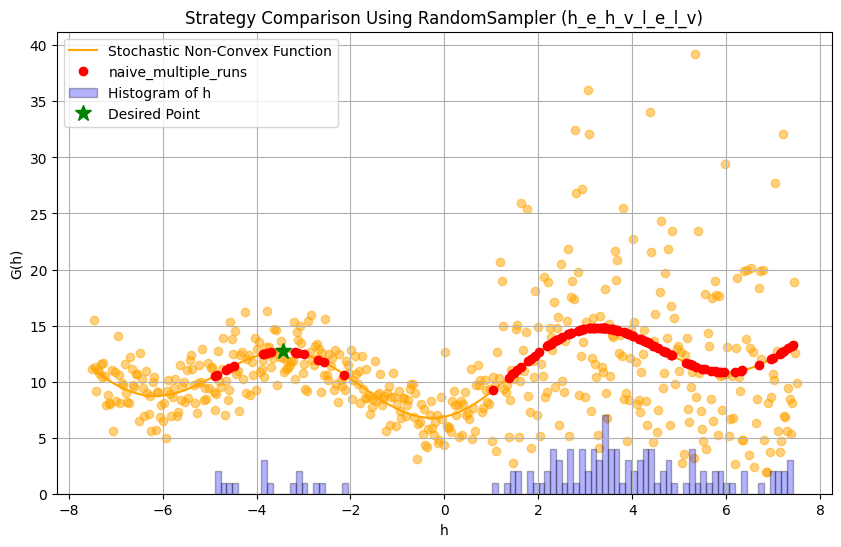

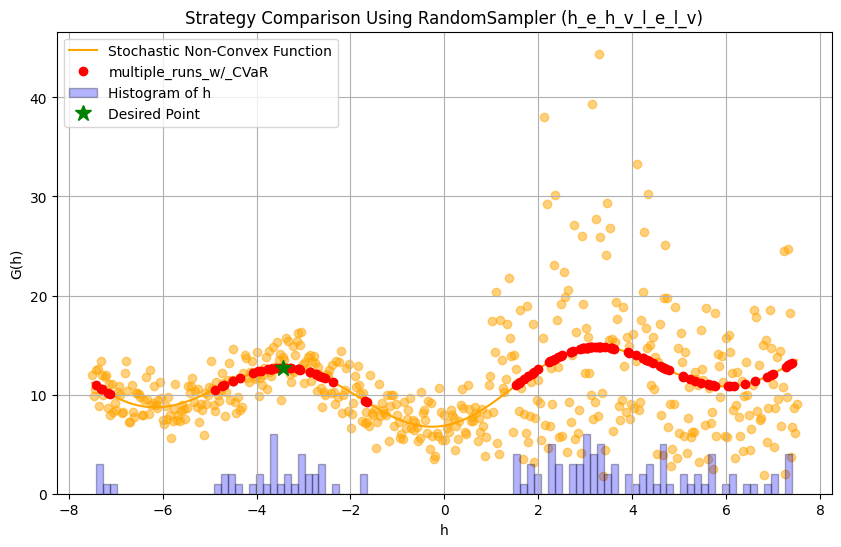

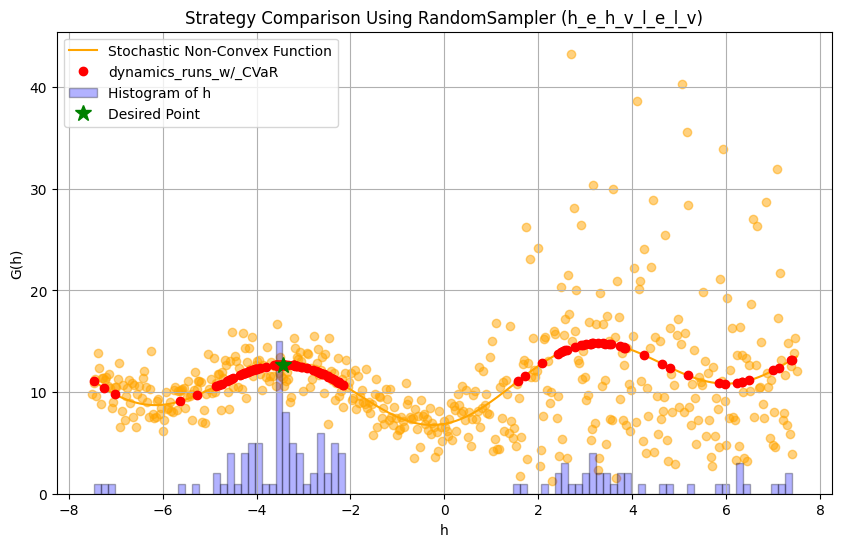

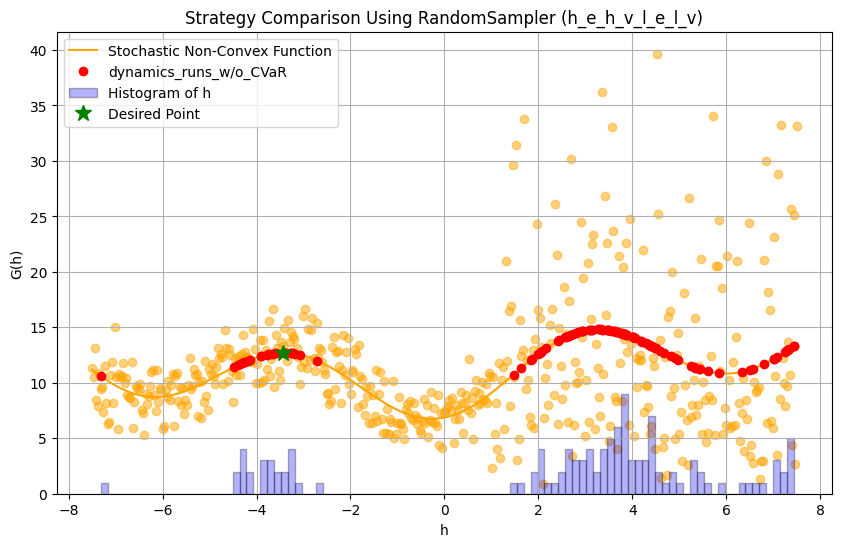

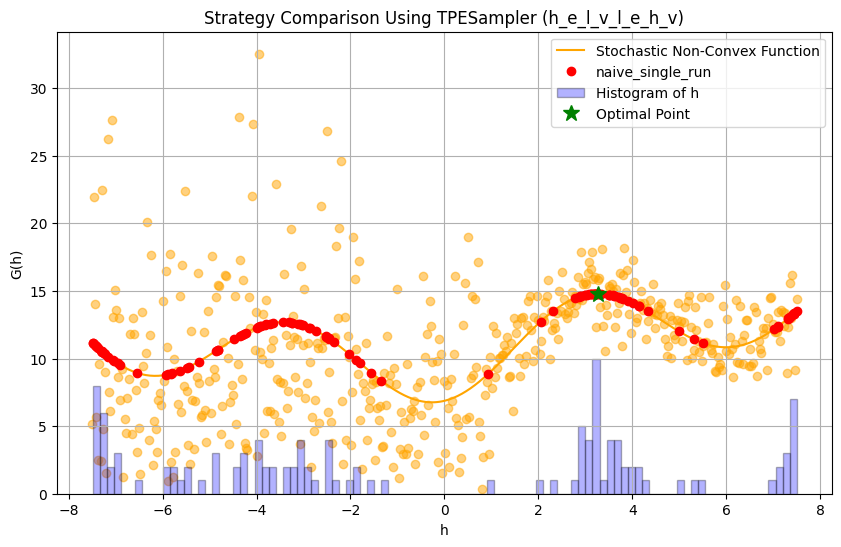

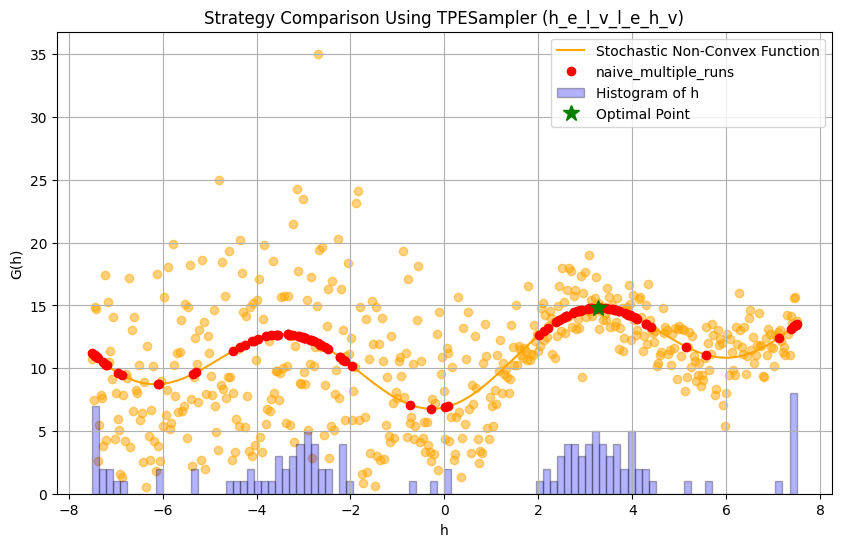

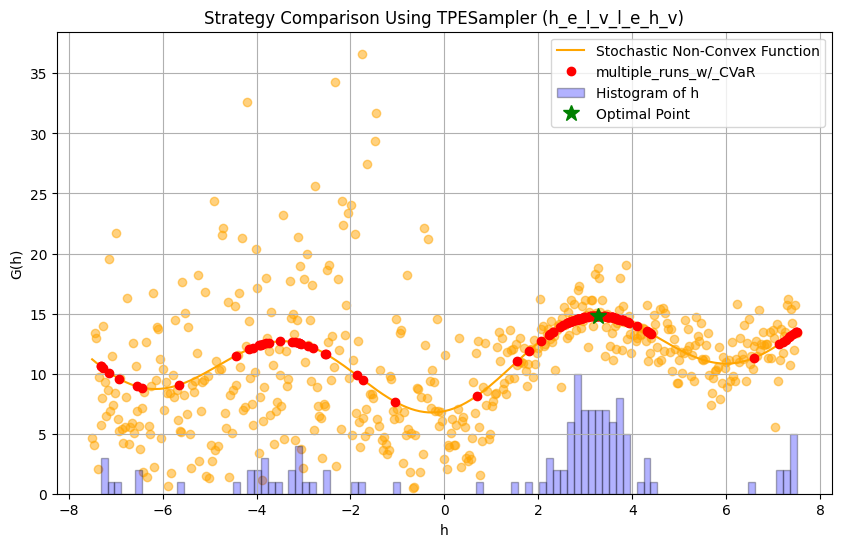

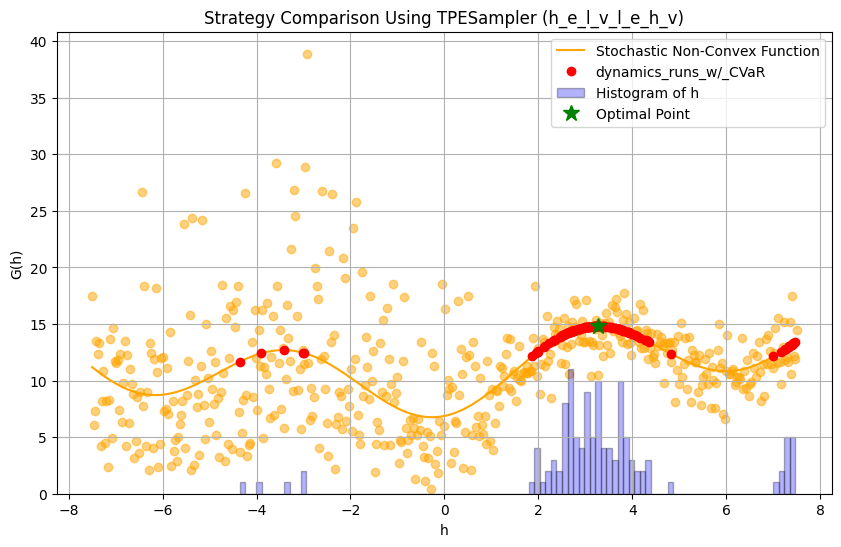

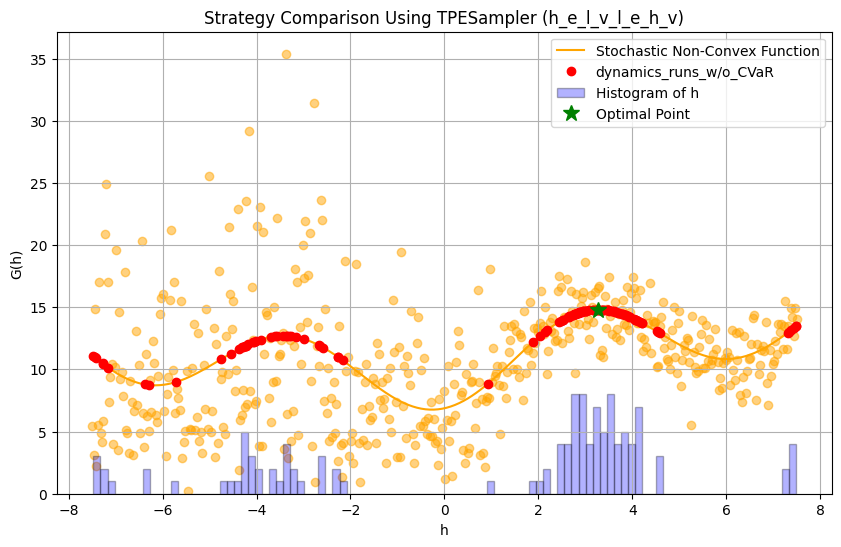

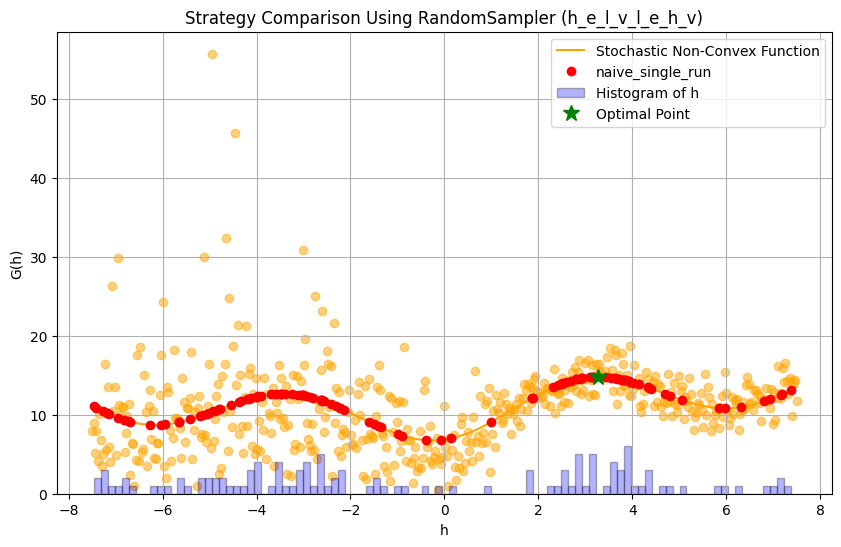

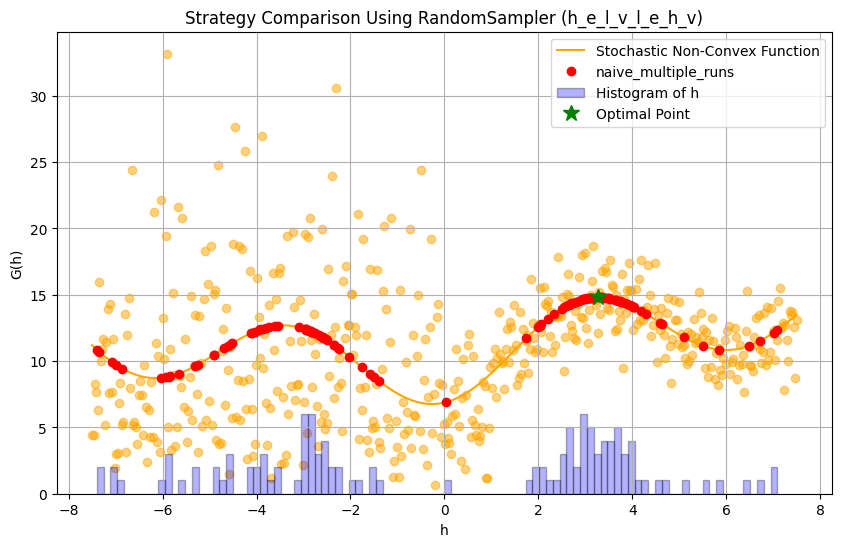

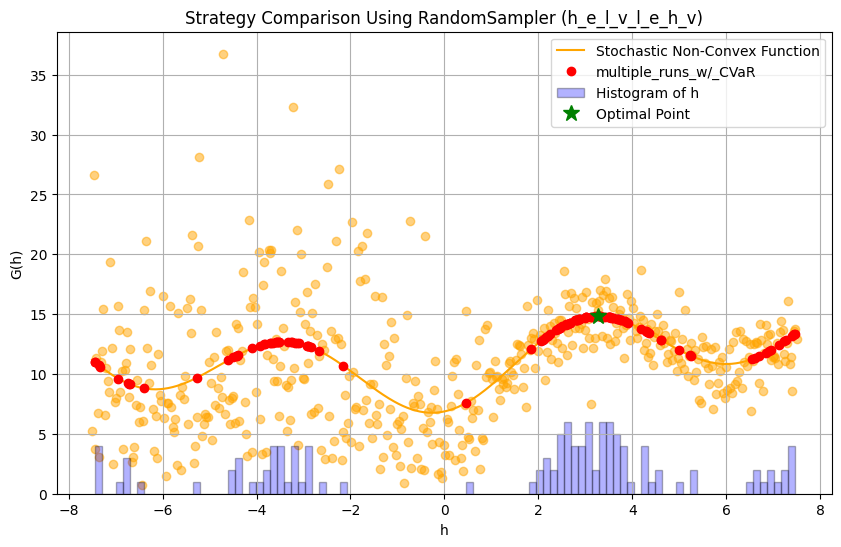

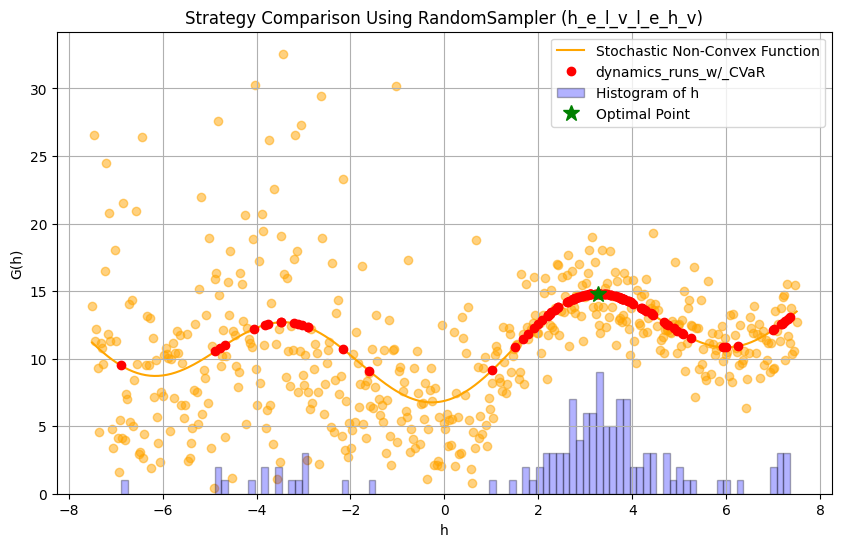

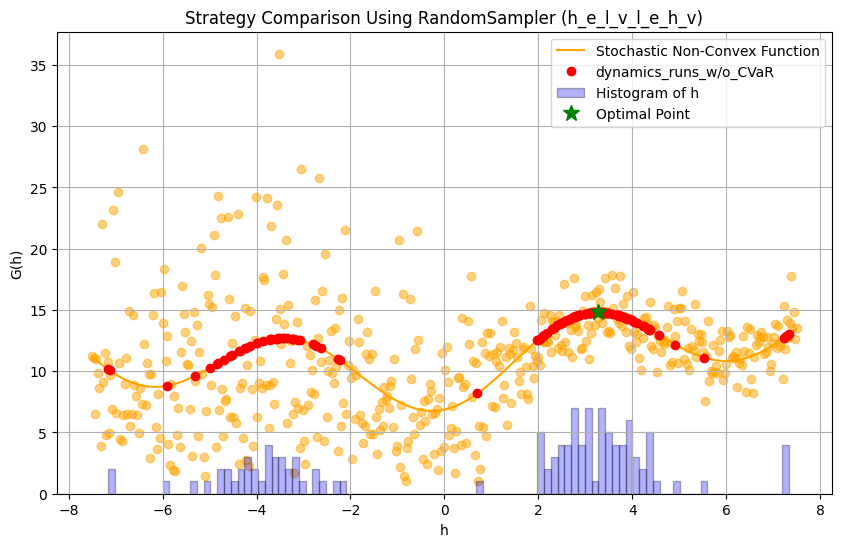

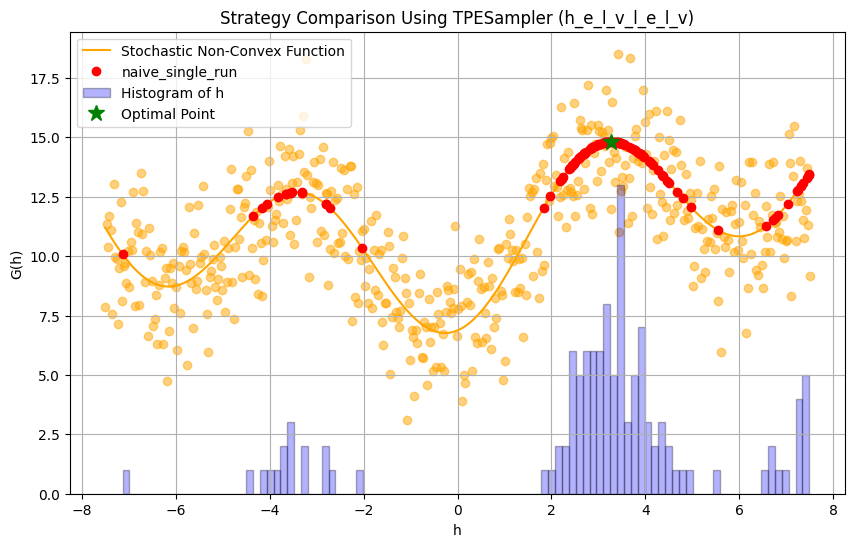

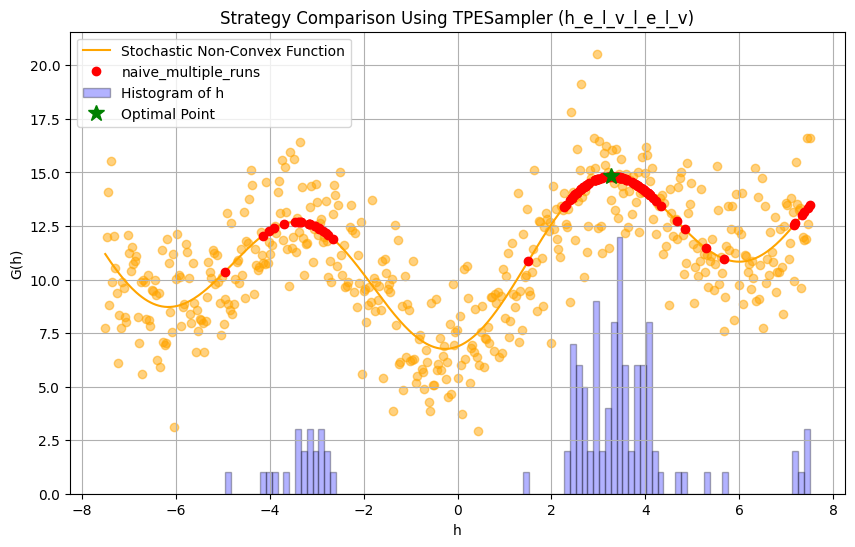

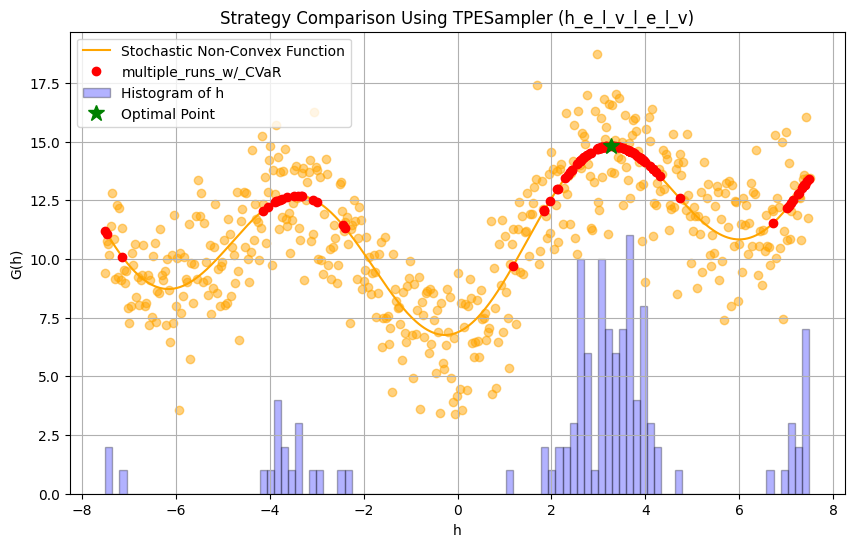

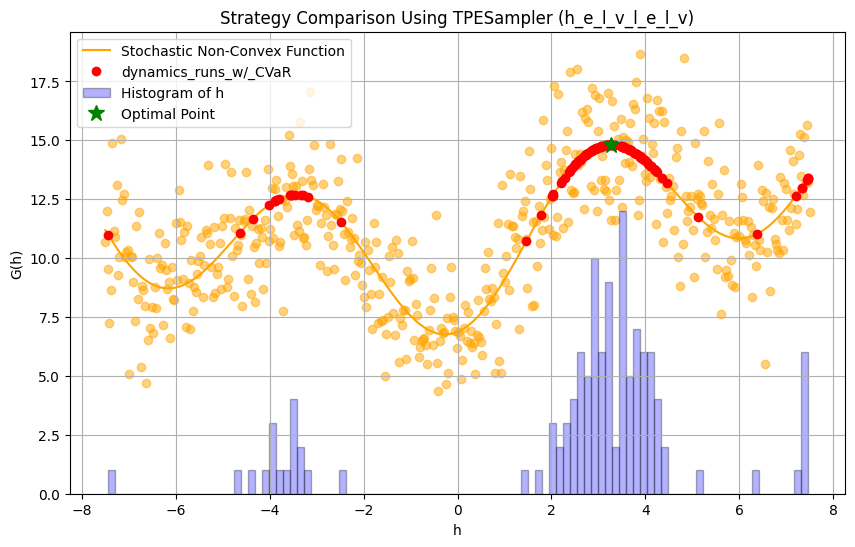

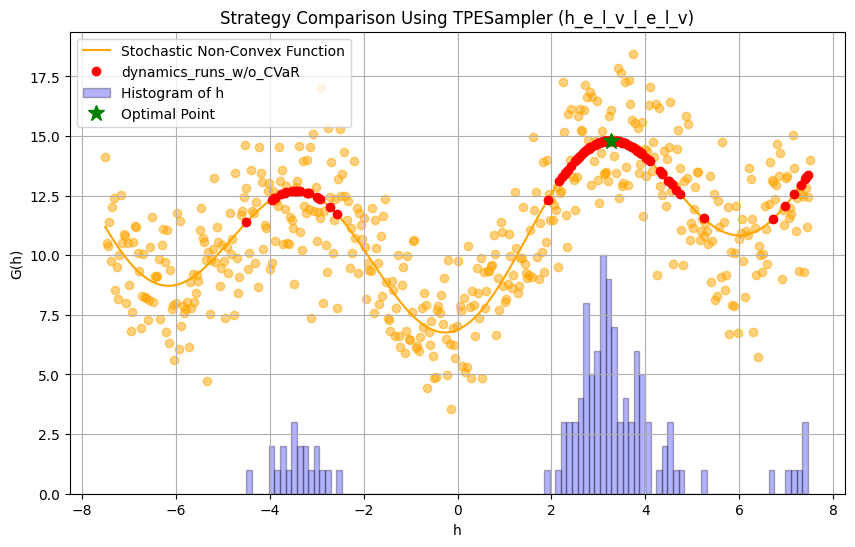

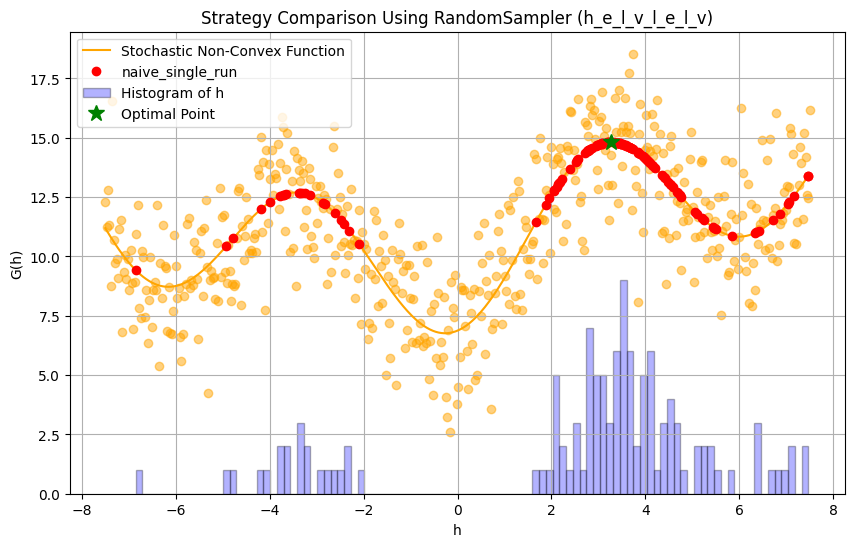

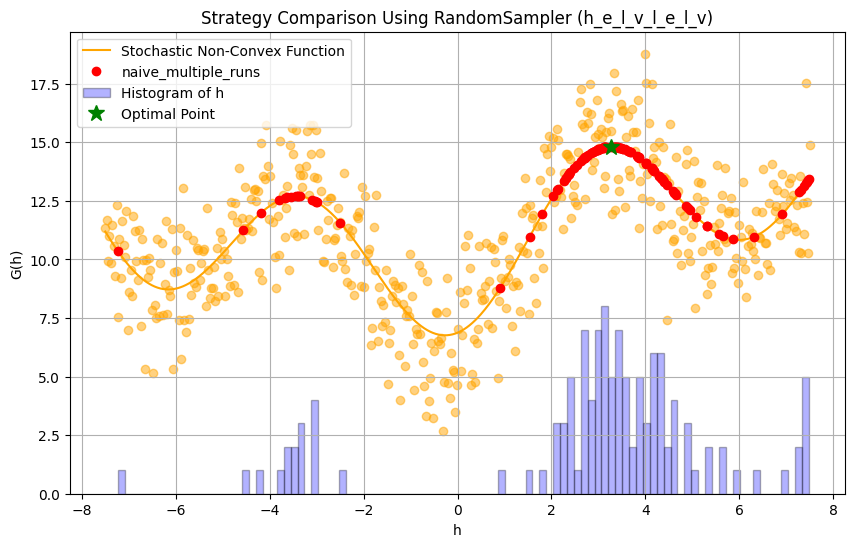

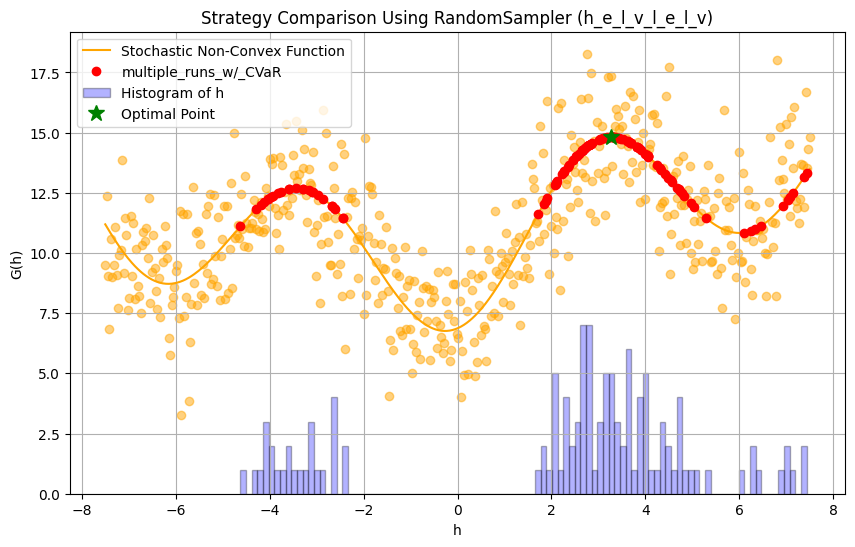

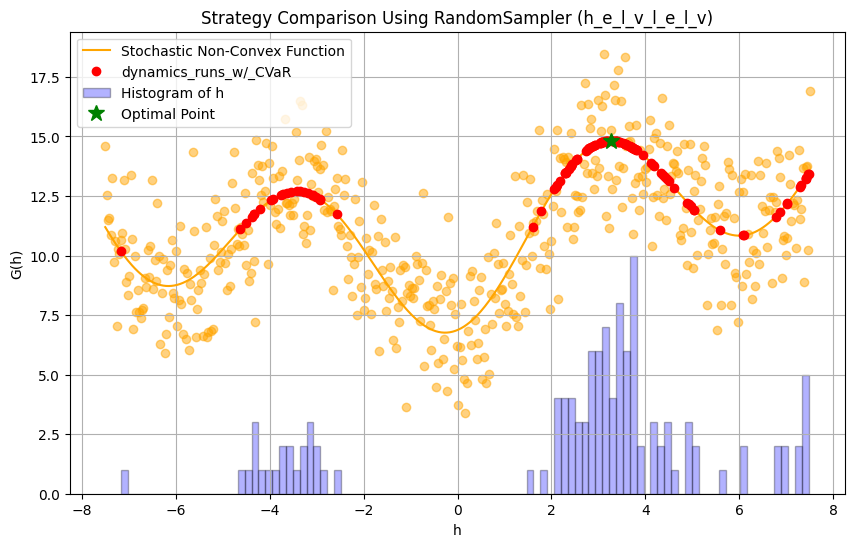

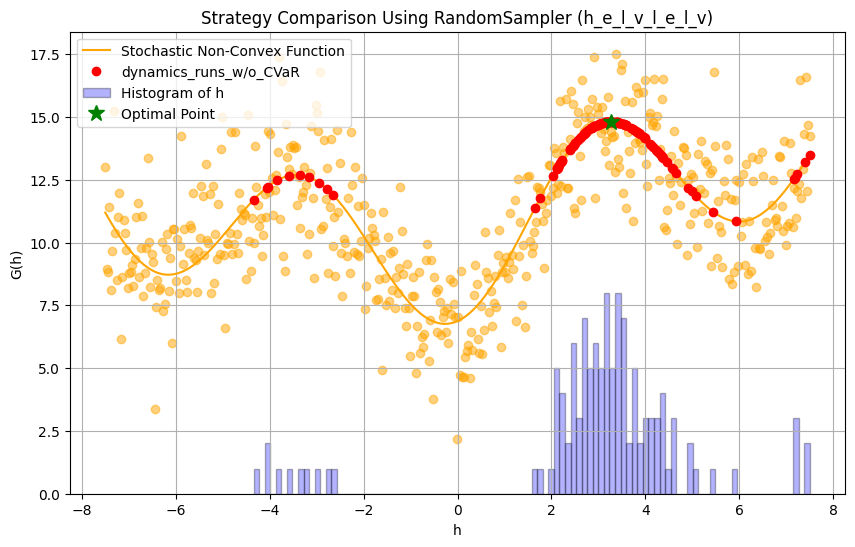

In [49]:
samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR",
              "dynamics_runs_w/o_CVaR"]
budgets = ['num_of_trials', 'num_of_eval']
trial_to_describe = 10
# visualize the results
for noise_function_mode in noise_function_modes:
    for sampler in samplers:
        for strategy in strategies:
            plt.figure(figsize=(10, 6))
            # Calculate the noisy function values
            noisy_function_values = np.array([])
            stds = np.array([]) 
            for xi in x:
                # append the noisy function values to the array
                v, std = non_convex_noisy_function(xi, noise_function_mode)
                noisy_function_values = np.append(noisy_function_values, v)
                stds = np.append(stds, std) 
            plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
            # plot std
            # plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')

            plt.scatter(x, noisy_function_values, alpha=0.5, color='orange')
            # plot data points for each strategy
            plt.plot(df[df['noise_function_modes'] == noise_function_mode][df['num_of_trials'] == trial_to_describe][df['Sampler'] == sampler][df['Strategy'] == strategy]['h'], 
                    df[df['noise_function_modes'] == noise_function_mode][df['num_of_trials'] == trial_to_describe][df['Sampler'] == sampler][df['Strategy'] == strategy]['G'],
                    'o', label=strategy, color='red')
            plt.hist(df[df['noise_function_modes'] == noise_function_mode][df['num_of_trials'] == trial_to_describe][df['Sampler'] == sampler][df['Strategy'] == strategy]['h'],
                    bins=100, edgecolor='black', color='blue', alpha=0.3, label='Histogram of h')
            if noise_function_mode == 'h_e_h_v_l_e_l_v':
                # plot the optimal point for x < 0 
                plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                         np.max(original_function_values[:int(len(original_function_values)/2)]), 
                         '*', markersize=12, label="Desired Point", color='green')
            else:
                # plot the optimal point from original_function_values in green
                plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                        '*', markersize=12, label="Optimal Point", color='green')
            plt.xlabel('h')
            plt.ylabel('G(h)')
            plt.title('Strategy Comparison Using ' + sampler + f' ({noise_function_mode})')
            plt.legend()
            plt.grid(True)
            plt.show()
            plt.close()

In [33]:
# only describe certain num_of_trials and G
df[df['num_of_trials'] == trial_to_describe].groupby(['Sampler', 'noise_function_modes', 'Strategy', 'num_of_trials']).describe()['G']

count  \
Sampler       noise_function_modes Strategy               num_of_trials          
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
TPESampler    h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   

                                                                              mean  \
Sampler       noise_function_modes Strategy               num_of_trials              
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             12.517536   
                                   dynamics_runs_w/o_CVaR 10             12.805059   
                                   multiple_runs_w/_CVaR  10             12.590399   
                                   naive_multiple_runs    10             12.225383   
                                   naive_single_run       10             12.055378   
              h_e_h_v_l_e_

In [34]:
# only describe certain num_of_trials and std
df[df['num_of_trials'] == trial_to_describe].groupby(['Sampler', 'noise_function_modes', 'Strategy', 'num_of_trials']).describe()['std']

count  \
Sampler       noise_function_modes Strategy               num_of_trials          
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
TPESampler    h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   

                                                                             mean  \
Sampler       noise_function_modes Strategy               num_of_trials             
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             7.227003   
                                   dynamics_runs_w/o_CVaR 10             7.393004   
                                   multiple_runs_w/_CVaR  10             7.269070   
                                   naive_multiple_runs    10             7.058328   
                                   naive_single_run       10             6.960176   
              h_e_h_v_l_e_l_v    

In [35]:
# only describe certain num_of_trials and h
df[df['num_of_trials'] == trial_to_describe].groupby(['Sampler', 'noise_function_modes', 'Strategy', 'num_of_trials']).describe()['h']

count  \
Sampler       noise_function_modes Strategy               num_of_trials          
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
TPESampler    h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   

                                                                             mean  \
Sampler       noise_function_modes Strategy               num_of_trials             
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             0.990741   
                                   dynamics_runs_w/o_CVaR 10             1.396563   
                                   multiple_runs_w/_CVaR  10             1.720581   
                                   naive_multiple_runs    10             1.804070   
                                   naive_single_run       10             1.160921   
              h_e_h_v_l_e_l_v    